#Import Library

In [108]:
import pandas as pd
import numpy as np

# library untuk lvisualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# library untuk analisis time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# library yang digunakan untuk forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#SEMMA
SEMMA adalah singkatan dari Sample, Explore, Modify, Model, dan Assess. Ini adalah daftar langkah berurutan yang dikembangkan oleh SAS Institute

#Sample

Memanggil Dataset

In [109]:
df = pd.read_csv('AirPassengers.csv')

Deskripsi Dataset

In [110]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


#Explore

In [113]:
df['Month']=pd.to_datetime(df['Month'], format='%Y-%m-%d')


In [114]:
df.set_index(['Month'], inplace=True)

In [115]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [116]:
df.index.min(), df.index.max()

(Timestamp('1949-01-01 00:00:00'), Timestamp('1960-12-01 00:00:00'))

In [117]:
if (df.index.max() - df.index.min() == 214):
    print ('Data is Continous')

<Axes: xlabel='Month'>

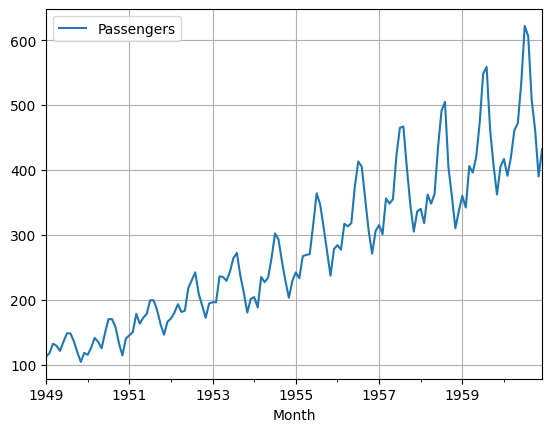

In [119]:
df.plot(grid=True)

In [120]:
train_df = df.loc[:'1949-01-01']
test_df = df.loc['1949-02-01':]

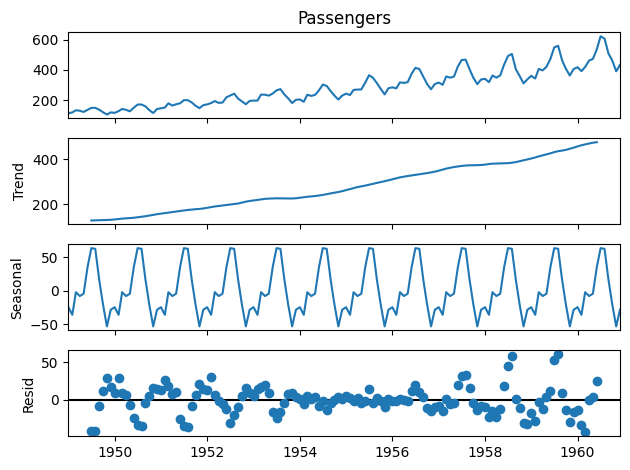

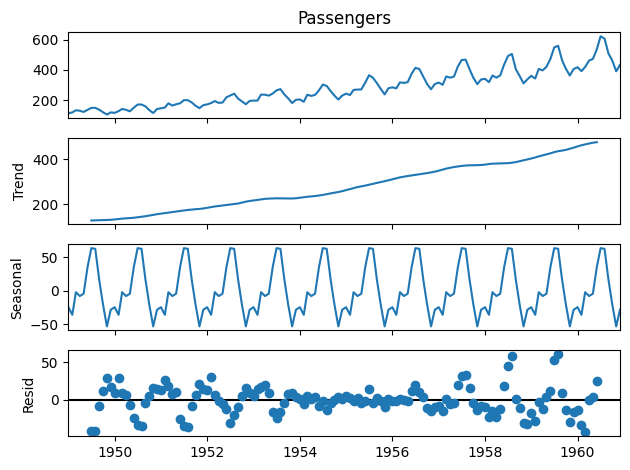

In [121]:
decompose_add = seasonal_decompose(df['Passengers'])
decompose_add.plot()

In [122]:
def adf_test(timeseries):
    print ('Hasil testing Dickey-Fuller')
    print ('----------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test statistic','p-value','Lags Used','Number of Observation Used'])
    for key, Value in adftest[4].items() :
        adf_output['Critical Value (%s)' %key] = Value
    print (adf_output)

adf_test(df.values)

Hasil testing Dickey-Fuller
----------------------------------
Test statistic                  0.815369
p-value                         0.991880
Lags Used                      13.000000
Number of Observation Used    130.000000
Critical Value (1%)            -3.481682
Critical Value (5%)            -2.884042
Critical Value (10%)           -2.578770
dtype: float64


In [123]:
diff_df = df.diff()
diff_df.head()

,Passengers
Month,
1949-01-01,NaN
1949-02-01,6.0
1949-03-01,14.0
1949-04-01,-3.0
1949-05-01,-8.0


In [124]:
diff_df.dropna(inplace=True)

<Axes: xlabel='Month'>

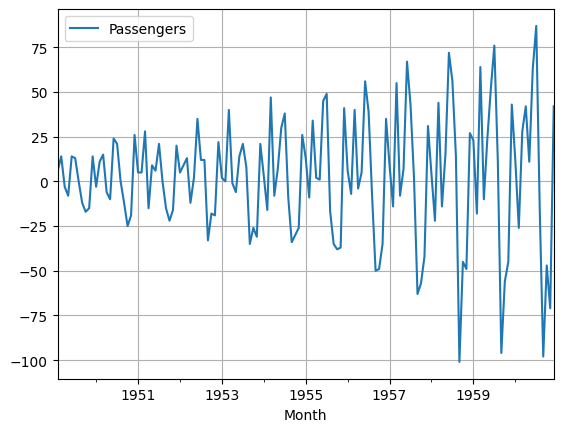

In [125]:
diff_df.plot(grid=True)

In [126]:
adf_test(diff_df)

Hasil testing Dickey-Fuller
----------------------------------
Test statistic                 -2.829267
p-value                         0.054213
Lags Used                      12.000000
Number of Observation Used    130.000000
Critical Value (1%)            -3.481682
Critical Value (5%)            -2.884042
Critical Value (10%)           -2.578770
dtype: float64


#Modify

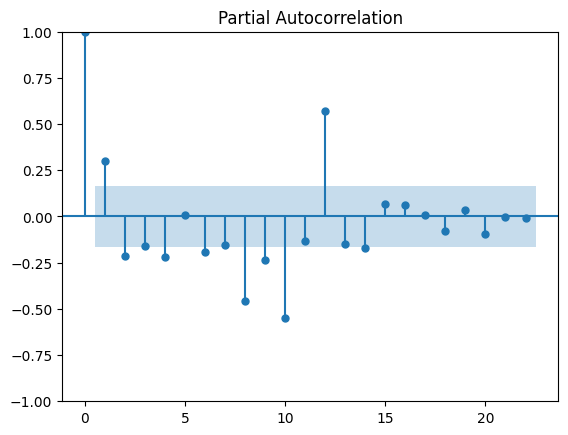

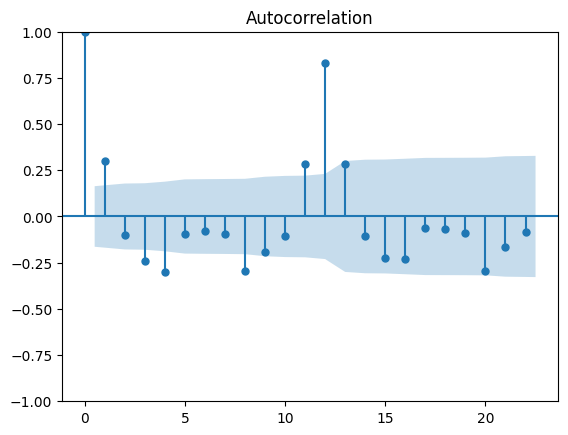

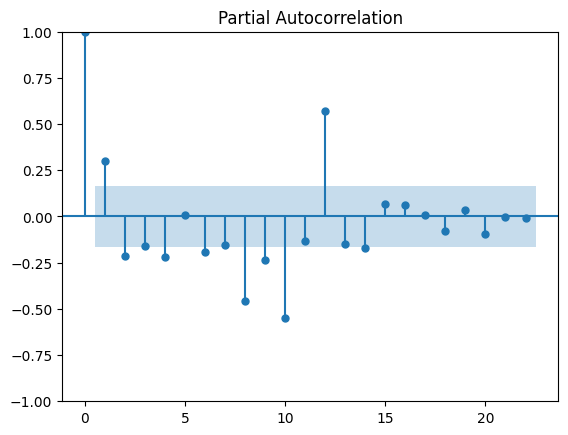

In [127]:
plot_acf(diff_df)
plot_pacf(diff_df)

In [128]:
adf = adfuller(df['Passengers'])
print(adf)

alpha = 0.05
if adf[1] <= alpha:
    print('Reject null hypothesis, The data is stationary')
else:
    print('Failed to reject null hypothesis, The data is not stationary')

(0.8153688792060498, 0.991880243437641, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019)
Failed to reject null hypothesis, The data is not stationary


In [129]:
# buat DataFrame untuk data yang stasioner
df_stationary = df.copy()

In [130]:
# differencing 1 kali
df_stationary['Passengers_Stationary'] = df_stationary['Passengers'].diff()

# differencing 2 kali
df_stationary['Passengers_Stationary_2'] = df_stationary['Passengers'].diff().diff()

In [131]:
df_stationary

,Passengers,Passengers_Stationary,Passengers_Stationary_2
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0
...,...,...,...
1960-08-01,606,-16.0,-103.0
1960-09-01,508,-98.0,-82.0
1960-10-01,461,-47.0,51.0


In [132]:
# drop baris pertama dan kedua
df_stationary = df_stationary.dropna()

In [133]:
# Dataframe untuk modeling
df_stationary

,Passengers,Passengers_Stationary,Passengers_Stationary_2
Month,,,
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0
1949-06-01,135,14.0,22.0
1949-07-01,148,13.0,-1.0
...,...,...,...
1960-08-01,606,-16.0,-103.0
1960-09-01,508,-98.0,-82.0
1960-10-01,461,-47.0,51.0


In [134]:
# cek setelah dilakukan differencing 1x apakah sudah stasioner

adf_stat = adfuller(df_stationary['Passengers_Stationary'])
print(adf_stat)

alpha = 0.05
if adf_stat[1] <= alpha:
    print('Reject null hypothesis; The data is stationary')
else:
    print('Failed to reject null hypothesis; The data is not stationary')

(-2.83342564556533, 0.053655499158908174, 12, 129, {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}, 980.990262745086)
Failed to reject null hypothesis; The data is not stationary


In [135]:
# cek setelah dilakukan differencing 2x apakah sudah stasioner

adf_stat = adfuller(df_stationary['Passengers_Stationary_2'])
print(adf_stat)

alpha = 0.05
if adf_stat[1] <= alpha:
    print('Reject null hypothesis; The data is stationary')
else:
    print('Failed to reject null hypothesis; The data is not stationary')

(-16.384231542468513, 2.7328918500142026e-29, 11, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 988.6020417275611)
Reject null hypothesis; The data is stationary


#Model

In [136]:
del df_stationary ['Passengers']
del df_stationary ['Passengers_Stationary']
df_stationary.head()

,Passengers_Stationary_2
Month,
1949-03-01,8.0
1949-04-01,-17.0
1949-05-01,-5.0
1949-06-01,22.0
1949-07-01,-1.0


In [137]:
ar = ARIMA(df_stationary, order=(15,1,15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(24)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

In [139]:
train_df_stationary = df_stationary.loc[:'1949-03-01']
test_df_stationary = df_stationary.loc['1949-02-01':]

<Axes: xlabel='Month'>

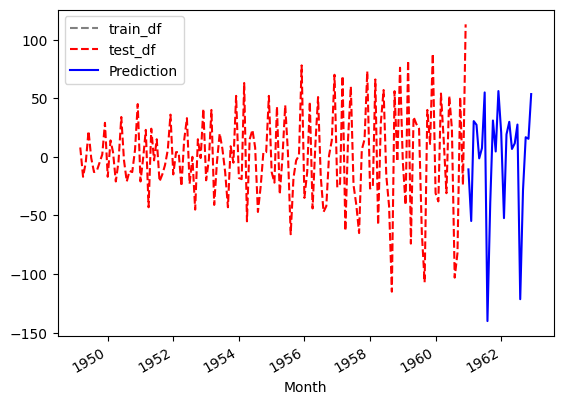

In [145]:
train_df_stationary['Passengers_Stationary_2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df_stationary['Passengers_Stationary_2'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='Prediction')

#Assess

In [156]:
ar = ARIMA(df_stationary, order=(15,1,15)).fit()
ar_test_pred = ar.forecast(20)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

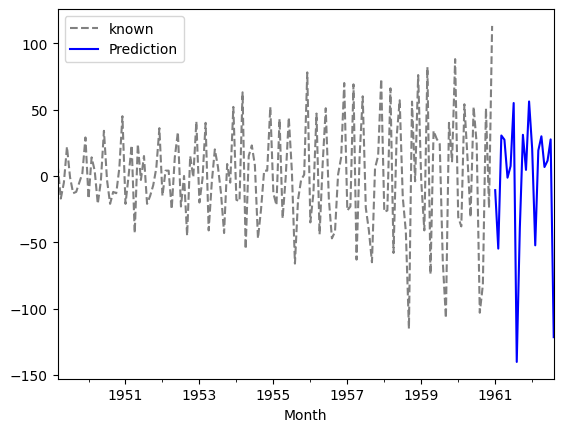

In [157]:
df_stationary['Passengers_Stationary_2'].plot(style='--', color='gray', legend=True, label='known')
ar_test_pred.plot(color='b', legend=True, label='Prediction')
plt.show()

In [159]:
import pickle
pickle.dump(ar, open('air_passenger_forecasting.sav','wb'))